### Import Library and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn import tree
from sklearn.metrics import accuracy_score , confusion_matrix , mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn import linear_model, tree, metrics, model_selection, exceptions, ensemble, metrics
from sklearn.metrics import fbeta_score

In [2]:
data_train = pd.read_csv("Data/train_validation_dataset.csv")
data_test = pd.read_csv("Data/test_dataset.csv")

<b> Note: EDA in notebook `Data_Extraction_and_Exploratory_Data_Analysis`

### Combining train and test data for pre-processing

In [3]:
# concatenating train and test set for pre-processing
# add a column to label train and test data, where train=0, test=1.

data_train['dataset'] = 0
data_test['dataset'] = 1
data = pd.concat([data_train, data_test])
print(data.shape)

(124900, 40)


<b> Pre-processing

In [4]:
# Change date column
from datetime import datetime
date = data['date']
data['date'] = pd.to_datetime(date).dt.strftime('%m/%Y')

# replace field that's entirely space (or empty) with NaN.
data = data.replace(r'^\s*$', 'NA', regex=True)

# impute missing values NaN with 0.
data = data.replace(np.nan, 0)

In [5]:
data = data.drop(['fullvisitorid', 'Unnamed: 0'], axis=1)

<b> Transformations - Encode Categorical Data 

In [6]:
# Show Cateogrical columns using .select_dtypes()
cat_data = data.select_dtypes(include=[object]) # use this for sklearn's encoders

cat_data_cols = data.select_dtypes(
    include=[object]).columns  # use this for pd.get_dummies

print(cat_data.nunique())

date                 4
channelgrouping      8
campaign_today       5
medium_today         7
keyword_today      436
adcontent_today     24
devicecategory       3
continent            6
subcontinent        23
country            186
metro               71
city               354
operatingsystem      7
source_today         6
dtype: int64


In [7]:
data = pd.get_dummies(data, columns=cat_data_cols)

#### Split data back into train and test

- Split March-May 2017 data into Train and Validate <br>
- Jun 2017 data as Test <br>
- Perform MinMax Scaling <br>
- Perform undersampling to train data <br>

In [8]:
# move col 'dataset' to the last col.
data = data[[c for c in data if c not in ['dataset']] + ['dataset']]
# move col 'transactions' to the last col.
data = data[[c for c in data if c not in ['transactions_target']] + ['transactions_target']]

In [9]:
train = data[data['dataset'] == 0]
test = data[data['dataset'] == 1]

<b> Split train data to train-validation

In [11]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
from imblearn.under_sampling import RandomUnderSampler

X = train.drop(['transactions_target', 'transactionrevenue_target'], axis=1)
y = train['transactions_target']

X_train, X_val , y_train, y_val=model_selection.train_test_split(X,y,test_size=0.3, random_state=1234)

X_train = min_max_scaler.fit_transform(X_train)
X_val = min_max_scaler.transform(X_val)

rus = RandomUnderSampler(random_state=2019, sampling_strategy=1)
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

X_test = test.drop(['transactions_target', 'transactionrevenue_target'], axis=1)
y_test = test['transactions_target']

X_test = min_max_scaler.transform(X_test)

# Check train and test datasets
print(X_train.shape)
print(y_train.shape)
print(X_resampled.shape)
print(y_resampled.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(66424, 1162)
(66424,)
(5226, 1162)
(5226,)
(28468, 1162)
(28468,)
(30008, 1162)
(30008,)


## Classification Models

The following classification models were used: <br>
- Logistic Regression
- Random Forest
- Adaptive Boosting
- Light Gradient Boosting (LGB)
- Neural Network

<b> Define optimisation scorer

In [12]:
f2_scorer = metrics.make_scorer(metrics.fbeta_score, beta = 2)

<b> Define print score function

In [13]:
def print_score(model, X_test, y_test):
    predict=model.predict(X_test)
    print("Training score is {}".format(model.score(X_resampled, y_resampled)))
    print("Validation score is {}".format(model.score(X_test, y_test)))
    print('Recall:', recall_score(y_test, predict))
    print('Precision:', precision_score(y_test, predict))
    print('Accuracy:', accuracy_score(y_test, predict))
    print("f1:", f1_score(y_test, predict))
    print("f2:", fbeta_score(y_test, predict, beta=2), '\n')
    print('Classification Score')
    print(metrics.classification_report(y_test, predict))
    print('Confusion Matrix')
    print(metrics.confusion_matrix(y_test, predict))

## 1 - Logistic Regression

<b> Parameter Tuning

In [14]:
# parameters = {'solver': ['newton-cg', 'sag','lbfgs'],
#                'C': [0.01, 0.05, 0.1, 0.2, 0.5]
#                }

# rs_lr = model_selection.RandomizedSearchCV(LogisticRegression(penalty='l2', random_state=1, class_weight='balanced'),
#                                             parameters,scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=5, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_lr.fit(X_resampled, y_resampled)

# #results
# rs_lr.best_estimator_
# # LogisticRegression(C=0.5, class_weight='balanced', dual=False,
# #                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
# #                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
# #                    random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
# #                    warm_start=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.3s finished
C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2019, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=1,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.05, 0.1, 0.2, 0.5],
                                        'solver': ['newton-cg', 'sag',
                                                

<b> Logistic Regression Model

In [16]:
lr = LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

lr.fit(X_resampled,y_resampled)

C:\Users\evelyn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<b> Prediction with Validation Data (Logistic Regression)

In [17]:
print_score(lr, X_val, y_val)

Training score is 0.8541905855338691
Validation score is 0.8106294787129409
Recall: 0.8755803156917363
Precision: 0.1520967741935484
Accuracy: 0.8106294787129409
f1: 0.25917273601758967
f2: 0.4487057480015227 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     27391
           1       0.15      0.88      0.26      1077

    accuracy                           0.81     28468
   macro avg       0.57      0.84      0.58     28468
weighted avg       0.96      0.81      0.87     28468

Confusion Matrix
[[22134  5257]
 [  134   943]]


<b> Feature Importance (Logistic Regression)

In [19]:
lr_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': lr.coef_[0] })
print(lr_importance.sort_values('importance',ascending=False).head(10))

                       feature  importance
3             timeonsite_today    7.355784
1                   hits_today    6.464427
2              pageviews_today    6.398894
0                     sessions    1.752458
19             transactions_lt    1.234508
715      country_United States    1.063559
32      channelgrouping_Social    0.997356
7                    visits_st    0.980493
1117              city_Toronto    0.842809
33    campaign_today_(not set)    0.841220


In [20]:
print(lr_importance.sort_values('importance',ascending=False).tail(10))

                             feature  importance
29    channelgrouping_Organic Search   -0.501592
1028                  city_Palo Alto   -0.520610
700                   country_Taiwan   -0.527953
13             transactionrevenue_st   -0.574643
1053               city_Redwood City   -0.579981
739        metro_Dallas-Ft. Worth TX   -0.614900
512                 continent_Europe   -0.771015
5                    newvisits_today   -0.865684
44             medium_today_referral   -0.867285
1160         source_today_b'youtube'   -1.437531


## 2 - Random Forest Modelling

<b> Parameter Tuning

In [21]:
# parameters = {'criterion': ['gini', 'entropy'],
#                'max_depth': [5, 10, 15, 20],
#                'min_samples_leaf': [1, 2],
#                'min_samples_split': [2, 4, 6],
#                'n_estimators': [10, 20, 30, 40],
#                'class_weight': ['balanced', 'balanced_subsample', None]
#                }

# rs_rf = model_selection.RandomizedSearchCV(ensemble.RandomForestClassifier(random_state=1),
#                                             parameters,scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=10, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_rf.fit(X_resampled, y_resampled)
# # print('best parameters: ', rs_rf.best_params_)

# ##results
# rs_rf.best_estimator_
# # RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
# #                        max_depth=15, max_features='auto', max_leaf_nodes=None,
# #                        min_impurity_decrease=0.0, min_impurity_split=None,
# #                        min_samples_leaf=2, min_samples_split=4,
# #                        min_weight_fraction_leaf=0.0, n_estimators=20,
# #                        n_jobs=None, oob_score=False, random_state=1, verbose=0,
# #                        warm_start=False)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

<b> Random Forest Model

In [23]:
rf = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


rf.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

<b> Prediction with Validation Data (Random Forest)

In [24]:
print_score(rf, X_val, y_val)

Training score is 0.9087256027554536
Validation score is 0.8698889981733877
Recall: 0.9238625812441968
Precision: 0.2155079055663851
Accuracy: 0.8698889981733877
f1: 0.3494906919564454
f2: 0.5574229691876751 

Classification Score
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     27391
           1       0.22      0.92      0.35      1077

    accuracy                           0.87     28468
   macro avg       0.61      0.90      0.64     28468
weighted avg       0.97      0.87      0.91     28468

Confusion Matrix
[[23769  3622]
 [   82   995]]


<b> Feature Importance for Random Forest

In [25]:
rf_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': rf.feature_importances_ })
print(rf_importance.sort_values('importance',ascending=False).head(10))

                           feature  importance
2                  pageviews_today    0.217906
3                 timeonsite_today    0.159029
1                       hits_today    0.125500
526  subcontinent_Northern America    0.047767
715          country_United States    0.038749
512               continent_Europe    0.032186
723                        metro_0    0.024320
510             continent_Americas    0.022365
17                   timeonsite_lt    0.018214
16                    pageviews_lt    0.017206


## 3 - Adaptive Boosting

<b> Parameter Tuning

In [26]:
# parameters = {'base_estimator__criterion' : ["gini", "entropy"], 
#               'base_estimator__splitter' :   ["best", "random"],
#               'base_estimator__max_depth': [15, 20, 25, 30], 
#               'base_estimator__min_samples_split': list(range(15, 30, 5)),
#               'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 
#               'n_estimators': list(range(50, 200, 50))}

# DTC = tree.DecisionTreeClassifier(random_state = 2019, max_features = "auto", class_weight = "balanced")

# rs_ab = model_selection.RandomizedSearchCV(ensemble.AdaBoostClassifier(random_state = 2019, base_estimator = DTC), 
#                                   parameters, scoring = f2_scorer, 
#                                   cv = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2019),
#                                        iid=False, verbose=2, n_jobs=-1)

# rs_ab.fit(X_resampled, y_resampled)

# #results
# rs_ab.best_estimator_
# # AdaBoostClassifier(algorithm='SAMME',
# #                    base_estimator=DecisionTreeClassifier(class_weight='balanced',
# #                                                          criterion='gini',
# #                                                          max_depth=30,
# #                                                          max_features='auto',
# #                                                          max_leaf_nodes=None,
# #                                                          min_impurity_decrease=0.0,
# #                                                          min_impurity_split=None,
# #                                                          min_samples_leaf=1,
# #                                                          min_samples_split=25,
# #                                                          min_weight_fraction_leaf=0.0,
# #                                                          presort=False,
# #                                                          random_state=2019,
# #                                                          splitter='best'),
# #                    learning_rate=0.01, n_estimators=150, random_state=2019)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=30,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=25,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                     

<b> AdaBoost Model

In [27]:
from sklearn.tree import DecisionTreeClassifier

ab= ensemble.AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=30,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=25,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                                                         splitter='best'),
                   learning_rate=0.01, n_estimators=150, random_state=2019)

ab.fit(X_resampled, y_resampled)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=30,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=25,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2019,
                     

<b> Prediction with Validation Data (Adaboost)

In [28]:
print_score(ab, X_val, y_val)

Training score is 0.9443168771526981
Validation score is 0.8750878179008009
Recall: 0.9201485608170845
Precision: 0.22214750056041246
Accuracy: 0.8750878179008009
f1: 0.3578909353557241
f2: 0.5650587296156917 

Classification Score
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     27391
           1       0.22      0.92      0.36      1077

    accuracy                           0.88     28468
   macro avg       0.61      0.90      0.64     28468
weighted avg       0.97      0.88      0.91     28468

Confusion Matrix
[[23921  3470]
 [   86   991]]


<b> Feature Importance for Adaptive Boosting

In [29]:
ab_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': ab.feature_importances_ })
print(ab_importance.sort_values('importance',ascending=False).head(10))

                            feature  importance
2                   pageviews_today    0.166543
1                        hits_today    0.151460
3                  timeonsite_today    0.117324
526   subcontinent_Northern America    0.038356
715           country_United States    0.037751
510              continent_Americas    0.034767
1151   operatingsystem_b'Macintosh'    0.018196
512                continent_Europe    0.016511
38              medium_today_(none)    0.015157
8                           hits_st    0.014886


## 4 - Neural Network

In [38]:
# from sklearn.neural_network import MLPClassifier
# parameters = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }

# rs_nn = model_selection.RandomizedSearchCV(MLPClassifier(random_state=2019, max_iter=100),
#                                             parameters,scoring = f2_scorer,
#                                             cv=model_selection.StratifiedKFold(
#                                                 n_splits=5, shuffle=True, random_state=2019),
#                                             verbose=2, n_jobs=-1)

# rs_nn.fit(X_resampled, y_resampled)
# rs_nn.best_estimator_

# # result
# # MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
# #               beta_2=0.999, early_stopping=False, epsilon=1e-08,
# #               hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
# #               learning_rate_init=0.001, max_iter=100, momentum=0.9,
# #               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
# #               random_state=2019, shuffle=True, solver='adam', tol=0.0001,
# #               validation_fraction=0.1, verbose=False, warm_start=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.3min finished


MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [39]:
from sklearn.neural_network import MLPClassifier

nn= MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

nn.fit(X_resampled, y_resampled)

MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

<b> Prediction with Validation Data (Neural Network)

In [40]:
print_score(nn, X_val, y_val)

Training score is 0.9008802143130501
Validation score is 0.8660601376984685
Recall: 0.9117920148560817
Precision: 0.20893617021276595
Accuracy: 0.8660601376984685
f1: 0.3399688419594945
f2: 0.5450710479573713 

Classification Score
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     27391
           1       0.21      0.91      0.34      1077

    accuracy                           0.87     28468
   macro avg       0.60      0.89      0.63     28468
weighted avg       0.97      0.87      0.90     28468

Confusion Matrix
[[23673  3718]
 [   95   982]]


## 5 - LightGBM

In [30]:
import lightgbm as lgb

<b> Parameter Tuning

In [31]:
# # coarse to fine tuning
# # parameter tuning guideline from: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# # Step 1 - coarse
# parameters = {'num_leaves': [10,20,30,40,50], 'min_data_in_leaf': [5, 10, 20, 30, 50, 100],'max_depth': [-1, 20, 40, 60, 100]}

# lgb_fit = model_selection.RandomizedSearchCV(lgb.LGBMClassifier(), parameters, scoring =  f2_scorer,
#                                    cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2019))
    
# lgb_fit.fit(X_resampled, y_resampled)
# print('best score:', lgb_fit.best_score_)
# print('best parameters: ', lgb_fit.best_params_)

# # results
# # best score: 0.8970572554385997
# # best parameters:  {'num_leaves': 10, 'min_data_in_leaf': 30, 'max_depth': -1}

# # Step 2 - fine
# # parameters = {'num_leaves': [30,50,70,90], 'min_data_in_leaf': [10,20,30,40],'max_depth': [100,120,140,160]}

# # lgb_fit = model_selection.RandomizedSearchCV(lgb.LGBMClassifier(), parameters, scoring =  f2_scorer,
# #                                    cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2019))
    
# # lgb_fit.fit(X_train, y_train)
# # print('best score:', lgb_fit.best_score_)
# # print('best parameters: ', lgb_fit.best_params_)
# # best score: 0.42790358761961755
# # best parameters:  {'num_leaves': 90, 'min_data_in_leaf': 10, 'max_depth': 160}

# # Note: to use step 1 tuning as it generate better score

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2019, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_le...
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,
                                            subsample_for_bin=200

<b> Light Gradient Boosting Model

In [33]:
lgb_c = lgb.LGBMClassifier(learning_rate = 0.04, n_estimators = 3200, boosting_type = 'dart', num_leaves = 10, min_data_in_leaf = 30, max_depth = -1)
lgb_c.fit(X_resampled, y_resampled,
          eval_set = [(X_val, y_val)],
          eval_metric = None,
          verbose = 500)

[500]	valid_0's binary_logloss: 0.288504
[1000]	valid_0's binary_logloss: 0.290441
[1500]	valid_0's binary_logloss: 0.295249
[2000]	valid_0's binary_logloss: 0.300176
[2500]	valid_0's binary_logloss: 0.305559
[3000]	valid_0's binary_logloss: 0.310895


LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.04, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=30, min_split_gain=0.0, n_estimators=3200,
               n_jobs=-1, num_leaves=10, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

<b> Prediction with Validation Data (LGB) 

In [65]:
print_score(lgb_c, X_val, y_val)

Training score is 0.9941587378056125
Validation score is 0.9692286075593649
Recall: 0.4232558139534884
Precision: 0.639943741209564
Accuracy: 0.9692286075593649
f1: 0.509518477043673
f2: 0.4540011973657953 

Classification Score
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     27393
           1       0.64      0.42      0.51      1075

   micro avg       0.97      0.97      0.97     28468
   macro avg       0.81      0.71      0.75     28468
weighted avg       0.96      0.97      0.97     28468

Confusion Matrix
[[27137   256]
 [  620   455]]


In [34]:
lgb_importance= pd.DataFrame.from_dict({'feature':list(X.columns), 'importance': lgb_c.feature_importances_ })
print(lgb_importance.sort_values('importance',ascending=False).head(10))

                           feature  importance
3                 timeonsite_today        5555
2                  pageviews_today        4462
1                       hits_today        2312
715          country_United States        1496
1151  operatingsystem_b'Macintosh'        1027
8                          hits_st         863
17                   timeonsite_lt         850
15                         hits_lt         817
31        channelgrouping_Referral         704
10                   timeonsite_st         672


### Precision Recall Chart - Validation Data

In [43]:
lr_proba_val=lr.predict_proba(X_val)[:, 1]
rf_proba_val=rf.predict_proba(X_val)[:, 1]
ab_proba_val=ab.predict_proba(X_val)[:, 1]
nn_proba_val=nn.predict_proba(X_val)[:, 1]
lgb_proba_val=lgb_c.predict_proba(X_val, num_iteration=lgb_c.best_iteration_)[:,1]

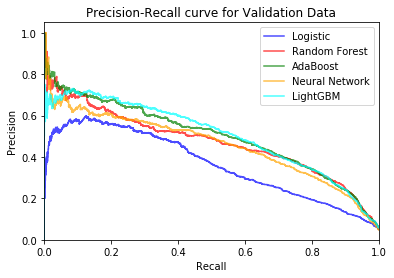

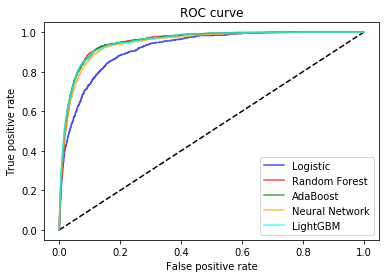

In [44]:
from inspect import signature

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_val, lr_proba_val)
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_val, rf_proba_val)
ab_precision, ab_recall, _ = metrics.precision_recall_curve(y_val, ab_proba_val)
nn_precision, nn_recall, _ = metrics.precision_recall_curve(y_val, nn_proba_val)
lgb_precision, lgb_recall, _ = metrics.precision_recall_curve(y_val, lgb_proba_val)

step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
plt.step(lr_recall, lr_precision, color='blue', alpha=0.7, where='post', label='Logistic')
plt.step(rf_recall, rf_precision, color='red', alpha=0.7, where='post', label='Random Forest')
plt.step(ab_recall, ab_precision, color='green', alpha=0.7, where='post', label='AdaBoost')
plt.step(nn_recall, nn_precision, color='orange', alpha=0.7, where='post', label='Neural Network')
plt.step(lgb_recall, lgb_precision, color='cyan', alpha=0.7, where='post', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Validation Data')
plt.legend(loc='best')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_val, lr_proba_val)
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_proba_val)
fpr_ab, tpr_ab, _ = roc_curve(y_val, ab_proba_val)
fpr_nn, tpr_nn, _ = roc_curve(y_val, nn_proba_val)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, lgb_proba_val)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic',color='blue', alpha=0.7)
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color='red', alpha=0.7)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost',color='green', alpha=0.7)
plt.plot(fpr_nn, tpr_nn, label='Neural Network',color='orange', alpha=0.7)
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM',color='cyan', alpha=0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Model Comparison - Test Data

<b> 1. Prediction with Test Data (Logistic Regression)

In [45]:
print ('Logistic Regression')
print_score(lr, X_test, y_test)

Logistic Regression
Training score is 0.8541905855338691
Validation score is 0.7741268994934684
Recall: 0.893760539629005
Precision: 0.137448132780083
Accuracy: 0.7741268994934684
f1: 0.23825578781748707
f2: 0.42549775208734747 

Classification Score
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     28822
           1       0.14      0.89      0.24      1186

    accuracy                           0.77     30008
   macro avg       0.57      0.83      0.55     30008
weighted avg       0.96      0.77      0.84     30008

Confusion Matrix
[[22170  6652]
 [  126  1060]]


<b> 2. Prediction with Test Data (Random Forest)

In [46]:
print ('Random Forest')
print_score(rf, X_test, y_test)

Random Forest
Training score is 0.9087256027554536
Validation score is 0.8417088776326312
Recall: 0.9215851602023609
Precision: 0.19008695652173913
Accuracy: 0.8417088776326312
f1: 0.3151672433679354
f2: 0.5207737754907567 

Classification Score
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     28822
           1       0.19      0.92      0.32      1186

    accuracy                           0.84     30008
   macro avg       0.59      0.88      0.61     30008
weighted avg       0.96      0.84      0.89     30008

Confusion Matrix
[[24165  4657]
 [   93  1093]]


<b> 3. Prediction with Test Data (Adaboost)

In [47]:
print ('Adaboost')
print_score(ab, X_test, y_test)

Adaboost
Training score is 0.9443168771526981
Validation score is 0.851139696081045
Recall: 0.9190556492411467
Precision: 0.19959714338033327
Accuracy: 0.851139696081045
f1: 0.32796750413720477
f2: 0.5340519353258207 

Classification Score
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     28822
           1       0.20      0.92      0.33      1186

    accuracy                           0.85     30008
   macro avg       0.60      0.88      0.62     30008
weighted avg       0.96      0.85      0.89     30008

Confusion Matrix
[[24451  4371]
 [   96  1090]]


<b> 4. Prediction with Test Data (Neural Network)

In [50]:
print ('Neural Network')
print_score(nn, X_test, y_test)

Neural Network
Training score is 0.9008802143130501
Validation score is 0.7972873900293255
Recall: 0.9300168634064081
Precision: 0.15528649866253696
Accuracy: 0.7972873900293255
f1: 0.26613584268307394
f2: 0.46551869671646834 

Classification Score
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     28822
           1       0.16      0.93      0.27      1186

    accuracy                           0.80     30008
   macro avg       0.58      0.86      0.57     30008
weighted avg       0.96      0.80      0.86     30008

Confusion Matrix
[[22822  6000]
 [   83  1103]]


<b> 5. Prediction with Validation Data (Light Gradient Boosting)

In [49]:
print('Light Gradient Boosting')
print_score(lgb_c, X_test, y_test)

Light Gradient Boosting
Training score is 0.9531190202831994
Validation score is 0.8594374833377766
Recall: 0.9089376053962901
Precision: 0.20778720123361605
Accuracy: 0.8594374833377766
f1: 0.33824913711954824
f2: 0.5426902939991946 

Classification Score
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     28822
           1       0.21      0.91      0.34      1186

    accuracy                           0.86     30008
   macro avg       0.60      0.88      0.63     30008
weighted avg       0.96      0.86      0.90     30008

Confusion Matrix
[[24712  4110]
 [  108  1078]]


### Precision Recall Chart - Test Data

In [51]:
lr_proba_test=lr.predict_proba(X_test)[:, 1]
rf_proba_test=rf.predict_proba(X_test)[:, 1]
ab_proba_test=ab.predict_proba(X_test)[:, 1]
nn_proba_test=nn.predict_proba(X_test)[:, 1]
lgb_proba_test=lgb_c.predict_proba(X_test, num_iteration=lgb_c.best_iteration_)[:,1]

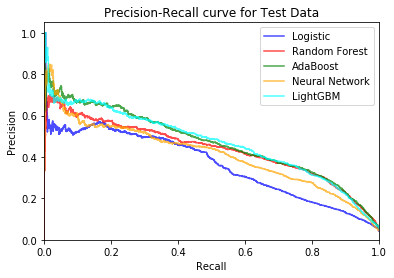

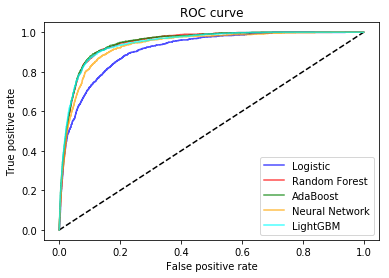

In [52]:
from inspect import signature

lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, lr_proba_test)
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_test, rf_proba_test)
ab_precision, ab_recall, _ = metrics.precision_recall_curve(y_test, ab_proba_test)
nn_precision, nn_recall, _ = metrics.precision_recall_curve(y_test, nn_proba_test)
lgb_precision, lgb_recall, _ = metrics.precision_recall_curve(y_test, lgb_proba_test)

step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
plt.step(lr_recall, lr_precision, color='blue', alpha=0.7, where='post', label='Logistic')
plt.step(rf_recall, rf_precision, color='red', alpha=0.7, where='post', label='Random Forest')
plt.step(ab_recall, ab_precision, color='green', alpha=0.7, where='post', label='AdaBoost')
plt.step(nn_recall, nn_precision, color='orange', alpha=0.7, where='post', label='Neural Network')
plt.step(lgb_recall, lgb_precision, color='cyan', alpha=0.7, where='post', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Test Data')
plt.legend(loc='best')
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba_test)
fpr_ab, tpr_ab, _ = roc_curve(y_test, ab_proba_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_proba_test)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_proba_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic',color='blue', alpha=0.7)
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color='red', alpha=0.7)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost',color='green', alpha=0.7)
plt.plot(fpr_nn, tpr_nn, label='Neural Network',color='orange', alpha=0.7)
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM',color='cyan', alpha=0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Threshold Curves - Test Data

In [53]:
def plot_prec_recall_vs_tresh(y_test, proba):
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, proba)
    
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.xlim([0,1.05])
    plt.ylim([0,1.05])

<b> Logistic Regression

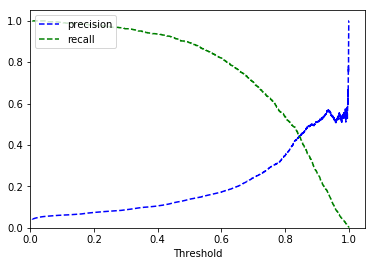

In [54]:
plot_prec_recall_vs_tresh(y_test, lr_proba_test)
plt.show()

<b> Random Forest

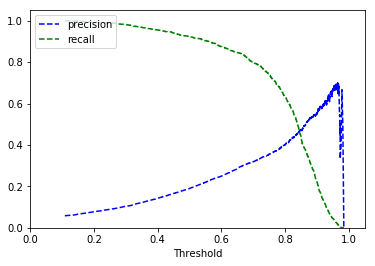

In [55]:
plot_prec_recall_vs_tresh(y_test, rf_proba_test)
plt.show()

<b> Adaptive Boosting

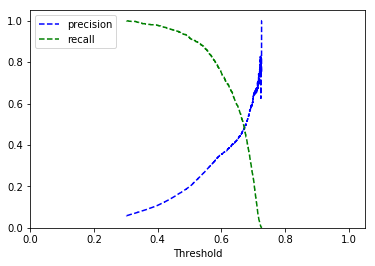

In [56]:
plot_prec_recall_vs_tresh(y_test, ab_proba_test)
plt.show()

<b> Neural Network

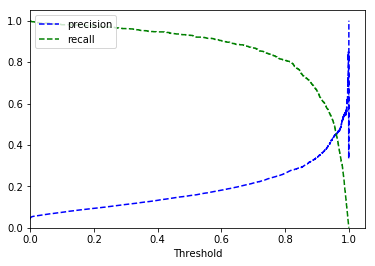

In [57]:
plot_prec_recall_vs_tresh(y_test, nn_proba_test)
plt.show()

<b> Light GBM

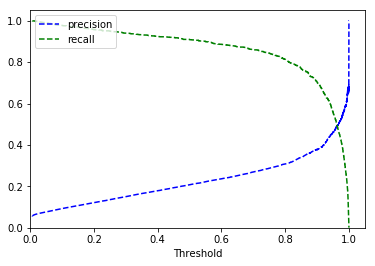

In [58]:
plot_prec_recall_vs_tresh(y_test, lgb_proba_test)
plt.show()

### Exporting Results

<b> Feature Importance

In [59]:
lr_importance.to_csv('Feature_Importance_03_LR.csv')
rf_importance.to_csv('Feature_Importance_03_RF.csv')
ab_importance.to_csv('Feature_Importance_03_AB.csv')
lgb_importance.to_csv('Feature_Importance_03_LGB.csv')

<b> Results

In [60]:
combine_proba=pd.concat([pd.DataFrame(lr_proba_test, columns=['Logistic_Regression']).reset_index(),
                         pd.DataFrame(rf_proba_test, columns=['Random_Forest']).reset_index(),
                         pd.DataFrame(ab_proba_test, columns=['AdaBoost']).reset_index(),
                         pd.DataFrame(nn_proba_test, columns=['Neural_Network']).reset_index(),
                         pd.DataFrame(lgb_proba_test, columns=['Light_GBM']).reset_index()
                        ], axis=1).drop('index', axis=1)

In [61]:
combine_with_data=pd.concat([pd.DataFrame(X_test, columns=X.columns).reset_index(), 
                             pd.DataFrame(y_test).reset_index(), 
                             combine_proba.reset_index()], axis=1).drop('index', axis=1)

In [62]:
combine_with_data.head(10)

,sessions,hits_today,pageviews_today,timeonsite_today,bounces_today,newvisits_today,ismobile,visits_st,hits_st,pageviews_st,...,source_today_b'others',source_today_b'partners',source_today_b'youtube',dataset,transactions_target,Logistic_Regression,Random_Forest,AdaBoost,Neural_Network,Light_GBM
0,0.0,0.0,0.004292,0.122858,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.320612,0.217619,0.333917,0.168927,0.009435
1,0.0,0.0,0.004292,0.001648,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.003554,0.027539,0.270022,0.000455,0.000011
2,0.0,0.0,0.004292,0.000577,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.098982,0.110857,0.288719,0.026959,0.002938
3,0.0,0.0,0.004292,0.001071,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.070644,0.035571,0.286571,0.117803,0.001872
4,0.0,0.0,0.004292,0.006427,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0,0.073303,0.161556,0.313365,0.041592,0.001625
5,0.0,0.0,0.004292,0.000082,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.020756,0.022837,0.269597,0.002097,0.000244
6,0.0,0.0,0.004292,0.003790,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.635904,0.145950,0.315284,0.147665,0.060274
7,0.0,0.0,0.004292,0.001401,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.135527,0.118673,0.304574,0.018556,0.001254
8,0.0,0.0,0.004292,0.015903,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.637634,0.446475,0.471754,0.332586,0.277161
9,0.0,0.0,0.004292,0.001401,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.595461,0.274467,0.458055,0.296773,0.346793


In [63]:
combine_with_data.to_csv('Result_03_No_FE.csv')

<b> Save Model

In [64]:
import pickle

with open('LR_03.pkl', 'wb') as file:  
    pickle.dump(lr, file)
    
with open('RF_03.pkl', 'wb') as file:  
    pickle.dump(rf, file)
    
with open('AB_03.pkl', 'wb') as file:  
    pickle.dump(ab, file)
    
with open('NN_03.pkl', 'wb') as file:  
    pickle.dump(ab, file)

with open('LightGBM_03.pkl', 'wb') as file:  
    pickle.dump(lgb_c, file)